In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor

# --- Parameters ---
dt = 1  # Time step
Cb1 = 24.9  # Concentration of stream 1
Cb2 = 0.1   # Concentration of stream 2
k1 = 1.0    # Reaction rate constant
k2 = 1.0    # Reaction parameter
N = 10    # Prediction horizon
L = 60      # Simulation steps
Q = 1.0     # Weight for tracking
R = 0.1     # Weight for control effort
w1_min, w1_max = 0.0, 4.0  # Control input bounds
delta_w1_max = 0.5  # Max rate of change for control input
Cb0 = 22.0  # Initial concentration
w2 = 0.1    # Disturbance input

### CSTR - Training data & ANN

In [6]:
# --- Neural Network Training ---
def generate_training_data(samples=1000):
    X, Y = [], []
    for _ in range(samples):
        w1 = np.random.uniform(w1_min, w1_max)
        Cb = np.random.uniform(20.0, 25.0)
        h = np.random.uniform(8.0, 12.0)
        dCb_dt = ((Cb1 - Cb) * w1 / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb)**2)
        Cb_next = Cb + dCb_dt * dt
        X.append([w1, Cb])
        Y.append(Cb_next)
    return np.array(X), np.array(Y)

X, Y = generate_training_data()
model = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=1000, activation='relu', solver='adam', learning_rate_init=0.01)
model.fit(X, Y)

# --- NN Prediction Function ---
def cstr_nn_step(Cb, w1, w2, model):
    return model.predict([[w1, Cb]])[0]


100%|██████████| 60/60 [00:04<00:00, 13.29it/s]


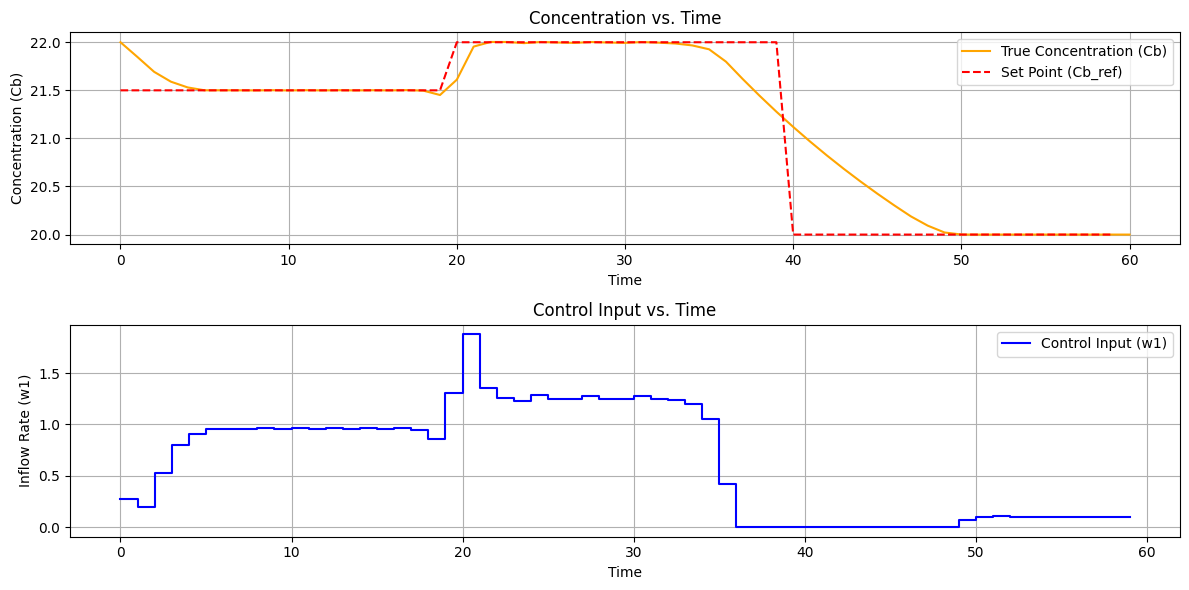

In [7]:
# --- Cost Function ---
def mpc_cost(w1_seq, w1_ini, Cb_ref, Cb0, w2, model, Q, R, N):
    cost = 0
    Cb = Cb0
    for idx in range(N):
        w1 = w1_seq[min(idx, len(w1_seq) - 1)]
        Cb = cstr_nn_step(Cb, w1, w2, model)
        cost += Q * (Cb_ref[idx] - Cb) ** 2
        if idx < len(w1_ini):
            cost += R * (w1 - w1_ini[idx]) ** 2
    return cost

# --- MPC Solver ---
def solve_mpc(Cb_ref, Cb, w1_ini, w2, model, Q, R, N, w1_min, w1_max, delta_w1_max):
    """
    Solve the MPC optimization problem.
    """
    # Ensure the reference trajectory matches the prediction horizon
    if len(Cb_ref) < N:
        Cb_ref = np.append(Cb_ref, [Cb_ref[-1]] * (N - len(Cb_ref)))  # Pad with the last value

    # Linear constraints on the rate of change of w1
    delta_w1_matrix = np.eye(N) - np.eye(N, k=1)
    rate_constraint = LinearConstraint(delta_w1_matrix, -delta_w1_max, delta_w1_max)

    # Bounds on the control input
    bounds = [(w1_min, w1_max) for _ in range(N)]

    # Solve the optimization problem
    result = minimize(
        mpc_cost,
        w1_ini,
        args=(w1_ini, Cb_ref, Cb, w2, model, Q, R, N),
        bounds=bounds,
        constraints=[rate_constraint],
    )

    # Handle optimization failures
    if not result.success:
        print("Optimization failed, using default control inputs")
        return np.ones(N) * w1_min

    return result.x

# --- Simulation Setup ---
Cb = np.zeros(L + 1)
Cb[0] = Cb0
w1 = np.zeros(L)
Cb_ref = np.array([21.5 if t < 20 else 22.0 if t < 40 else 20 for t in range(L)])
w1_ini = np.ones(N) * 2.0

for idx in tqdm(range(L)):
    # Adjust the reference trajectory slice for the prediction horizon
    Cb_ref_slice = Cb_ref[idx:idx+N]
    if len(Cb_ref_slice) < N:
        Cb_ref_slice = np.append(Cb_ref_slice, [Cb_ref_slice[-1]] * (N - len(Cb_ref_slice)))

    # Solve the MPC optimization problem
    w1_mpc = solve_mpc(
        Cb_ref_slice, Cb[idx], w1_ini, w2, model, Q, R, N, w1_min, w1_max, delta_w1_max
    )

    # Apply the first control input
    w1[idx] = w1_mpc[0]
    w1_ini = np.append(w1_mpc[1:], w1_mpc[-1])  # Shift control sequence

    # Update system state using NN
    Cb[idx + 1] = cstr_nn_step(Cb[idx], w1[idx], w2, model)

# --- Plot Results ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(range(L + 1), Cb, label="True Concentration (Cb)", color="orange")
plt.plot(range(L), Cb_ref, label="Set Point (Cb_ref)", linestyle="--", color="red")
plt.xlabel("Time")
plt.ylabel("Concentration (Cb)")
plt.title("Concentration vs. Time")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.step(range(L), w1, where="post", label="Control Input (w1)", color="blue")
plt.xlabel("Time")
plt.ylabel("Inflow Rate (w1)")
plt.title("Control Input vs. Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
